In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -U git+https://github.com/albu/albumentations > /dev/null && echo    

  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-j8w_pxpf



In [3]:
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 67.1 MB 35 kB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [4]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np                                      
from albumentations.pytorch import ToTensorV2

import torch
import albumentations as A
import numpy as np
import glob as glob
import torchvision
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, AnchorGenerator
from torch.utils.data import DataLoader, sampler, random_split, Dataset
from tqdm.auto import tqdm
import torchvision
from torchvision.utils import draw_bounding_boxes

import copy
import math
from typing import List, Optional

from torch import nn, Tensor

plt.style.use('ggplot')

In [5]:
!pip install pycocotools
from pycocotools.coco import COCO
# os.mkdir('/content/outputs')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
dataset_path = "/content/drive/MyDrive/Custom"
#load classes
coco = COCO(os.path.join(dataset_path, "Train", "dataset.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories
# OUT_DIR = '/content/outputs'
OUT_DIR ='/content/drive/MyDrive/Model'

loading annotations into memory...
Done (t=4.22s)
creating index...
index created!


In [7]:
classes = [i[1]['name'] for i in categories.items()]
classes

['Flute',
 'Bed',
 'Bridge',
 'Broom',
 'Door',
 'Fencing',
 'Grain Storage',
 'Hand Fan',
 'House',
 'Mask',
 'Jakoi',
 'Khaloi',
 'Dhol',
 'Pepa',
 'Conical Hat',
 'Jaw harp',
 'Winnowing Fan',
 'Toka',
 'Julki']

In [8]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0
        
    def send(self, value):
        self.current_total += value
        self.iterations += 1
    
    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations
    
    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [9]:
# define the training tranforms
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            #A.pytorch.transforms.ToTensorV2()
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            #A.pytorch.transforms.ToTensorV2
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

def get_valid_transform():
    return A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            #A.pytorch.transforms.ToTensorV2
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))

In [10]:
# the dataset class
class CustomDataset(torchvision.datasets.VisionDataset):
    def __init__(self, root, split='', transform=None, target_transform=None, transforms=None):
        # the 3 transform parameters are reuqired for datasets.VisionDataset
        super().__init__(root, transforms, transform, target_transform)
        self.split = split #train, valid, test
        self.coco = COCO(os.path.join(root, split, "dataset.json")) # annotatiosn stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]
    
    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))
    
    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))
        
        boxes = [t['bbox'] + [t['category_id']] for t in target] # required annotation format for albumentations
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)
        
        image = transformed['image']
        boxes = transformed['bboxes']
        
        new_boxes = [] # convert from xywh to xyxy
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])
        
        boxes = torch.tensor(new_boxes, dtype=torch.float32)
        
        targ = {} # here is our transformed target
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # we have a different area
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ # scale images

    def __len__(self):
        return len(self.ids)

In [11]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [12]:
train_dataset = CustomDataset(root=dataset_path, split="Train", transforms=get_transforms(True))
valid_dataset = CustomDataset(root=dataset_path, split="Test", transforms=get_valid_transform())

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=True, num_workers=2, collate_fn=collate_fn)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.58s)
creating index...
index created!


500

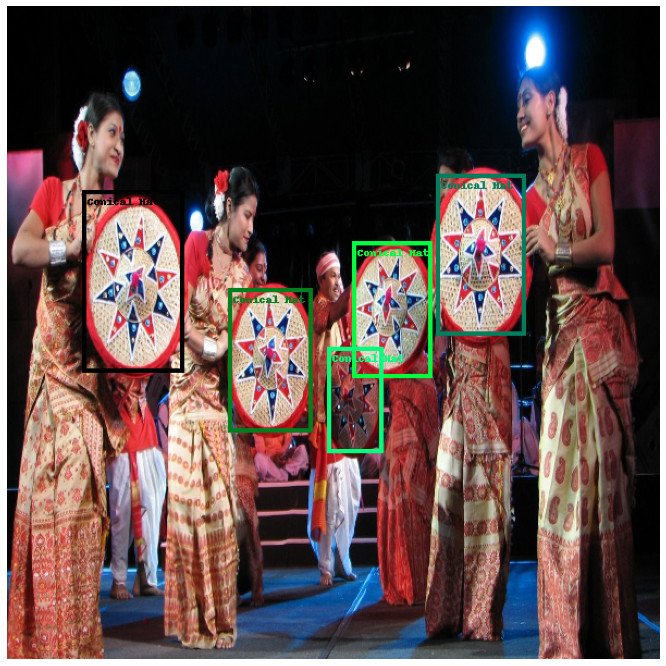

In [15]:
# Lets view a sample
sample = train_dataset[450]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
).permute(1, 2, 0))

len(train_dataset)

In [16]:
# from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
# backbone = resnet_fpn_backbone('resnet50', pretrained=True, trainable_layers=5)

# anchor_generator = AnchorGenerator(
#         sizes=((16,), (32,), (64,), (128,), (256,)),
#         aspect_ratios=tuple([(0.25, 0.5, 1.0, 2.0) for _ in range(5)]))

# roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'],
#                                                     output_size=7, sampling_ratio=2)

#     # put the pieces together inside a FasterRCNN model
# model = torchvision.models.detection.faster_rcnn.FasterRCNN(backbone, n_classes,
#                        rpn_anchor_generator=anchor_generator,
#                        box_roi_pool=roi_pooler)




# # load SSD pre-trained model
# # model = torchvision.models.detection.ssd300_vgg16(pretrained=True)
# model = torchvision.models.detection.ssdlite320_mobilenet_v3_large(pretrained=True)



# load Faster RCNN pre-trained model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
        pretrained=True)

# get the number of input features
in_features = model.roi_heads.box_predictor.cls_score.in_features
# define a new head for the detector with required number of classes
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, n_classes)




Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [ ]:
images,targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
output = model(images, targets) # just make sure this runs without error

In [19]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, 
                            lr=0.01, 
                            momentum=0.9, 
                            nesterov=True, 
                            weight_decay=1e-4)

In [ ]:
def save_model(epoch, model, optimizer):
    # torch.save({
    #             'epoch': epoch+1,
    #             'model_state_dict': model.state_dict(),
    #             'optimizer_state_dict': optimizer.state_dict(),
    #             }, 'outputs/last_model.pth')
    # torch.save(model.state_dict(), 'outputs/last_model.pth')
    torch.save(model.state_dict(), '/content/drive/MyDrive/Model/last_model.pth')

    
def save_loss_plot(OUT_DIR, train_loss, val_loss):
    figure_1, train_ax = plt.subplots()
    figure_2, valid_ax = plt.subplots()

    train_ax.plot(train_loss, color='tab:blue')

    train_ax.set_xlabel('iterations')
    train_ax.set_ylabel('train loss')
    
    valid_ax.plot(val_loss, color='tab:red')

    valid_ax.set_xlabel('iterations')
    valid_ax.set_ylabel('validation loss')

    figure_1.savefig(f"{OUT_DIR}/train_loss.png")
    figure_2.savefig(f"{OUT_DIR}/valid_loss.png")

    print('SAVING PLOTS COMPLETE...')
    plt.close('all')

In [ ]:
def train(train_data_loader, model):
    print('Training')
    global train_itr
    global train_loss_list
    
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))
    
    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets = data
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        train_loss_list.append(loss_value)
        train_loss_hist.send(loss_value)
        losses.backward()
        optimizer.step()
        train_itr += 1
    
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return train_loss_list

In [ ]:
def validate(valid_loader, model):
    print('Validating')
    global val_itr
    global val_loss_list
    
    prog_bar = tqdm(valid_loader, total=len(valid_loader))
    
    for i, data in enumerate(prog_bar):
        images, targets = data
        
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
        
        with torch.no_grad():
            loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        val_loss_list.append(loss_value)
        val_loss_hist.send(loss_value)
        val_itr += 1
        
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return val_loss_list

In [ ]:
# def check_accuracy(loader, model):
#     num_correct = 0
#     num_samples = 0
#     model.eval()

#     with torch.no_grad():
#         for x,y in loader:
#             # print(x)
#             # print(y)
#             x= list(x.to(device) for x in x)
#             y = [{k: v.to(device) for k, v in t.items()} for t in y]

#             scores = model(x)
#             _, predictions = scores.max(1)
#             num_correct += (predictions == y).sum()
#             num_samples += predictions.size(0)
#             accuracy = f'{float(num_correct) / float(num_samples) * 100:.3f}'

#         #print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct) / float(num_samples) * 100:.3f}')
#         return accuracy  


In [ ]:
num_epochs= 100

train_loss_hist = Averager()
val_loss_hist = Averager()

train_itr = 1
val_itr = 1

train_loss_list = []
val_loss_list = []

for epoch in range(num_epochs):

    train_loss_hist.reset()
    val_loss_hist.reset()

    # accuracy = check_accuracy(train_loader, model)

    train_loss = train(train_loader, model)
    val_loss = validate(valid_loader, model)

    
    print(f"Epoch #{epoch+1} train loss: {train_loss_hist.value:.3f}")  
    # print(f"Epoch #{epoch+1} Accuracy: {accuracy}")       
    print(f"Epoch #{epoch+1} validation loss: {val_loss_hist.value:.3f}")   

    save_model(epoch, model, optimizer)
    save_loss_plot(OUT_DIR, train_loss, val_loss)


Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #1 train loss: 0.410
Epoch #1 validation loss: 0.312
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #2 train loss: 0.322
Epoch #2 validation loss: 0.280
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #3 train loss: 0.273
Epoch #3 validation loss: 0.266
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #4 train loss: 0.242
Epoch #4 validation loss: 0.271
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #5 train loss: 0.228
Epoch #5 validation loss: 0.275
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #6 train loss: 0.205
Epoch #6 validation loss: 0.256
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #7 train loss: 0.184
Epoch #7 validation loss: 0.271
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #8 train loss: 0.180
Epoch #8 validation loss: 0.265
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #9 train loss: 0.161
Epoch #9 validation loss: 0.283
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #10 train loss: 0.154
Epoch #10 validation loss: 0.276
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #11 train loss: 0.142
Epoch #11 validation loss: 0.267
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #12 train loss: 0.129
Epoch #12 validation loss: 0.266
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #13 train loss: 0.130
Epoch #13 validation loss: 0.286
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #14 train loss: 0.125
Epoch #14 validation loss: 0.282
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #15 train loss: 0.134
Epoch #15 validation loss: 0.256
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #16 train loss: 0.115
Epoch #16 validation loss: 0.264
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #17 train loss: 0.109
Epoch #17 validation loss: 0.284
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #18 train loss: 0.099
Epoch #18 validation loss: 0.268
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #19 train loss: 0.098
Epoch #19 validation loss: 0.282
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #20 train loss: 0.092
Epoch #20 validation loss: 0.267
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #21 train loss: 0.087
Epoch #21 validation loss: 0.261
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #22 train loss: 0.095
Epoch #22 validation loss: 0.272
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #23 train loss: 0.089
Epoch #23 validation loss: 0.273
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #24 train loss: 0.080
Epoch #24 validation loss: 0.267
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #25 train loss: 0.078
Epoch #25 validation loss: 0.285
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #26 train loss: 0.081
Epoch #26 validation loss: 0.275
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #27 train loss: 0.076
Epoch #27 validation loss: 0.288
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #28 train loss: 0.073
Epoch #28 validation loss: 0.265
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #29 train loss: 0.071
Epoch #29 validation loss: 0.270
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #30 train loss: 0.071
Epoch #30 validation loss: 0.286
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbbe4f55440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbbe4f55440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbbe4f55440>
Traceback (most recent call last):
  File "/usr/local/lib/python3

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #31 train loss: 0.071
Epoch #31 validation loss: 0.273
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #32 train loss: 0.065
Epoch #32 validation loss: 0.289
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #33 train loss: 0.068
Epoch #33 validation loss: 0.314
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #34 train loss: 0.066
Epoch #34 validation loss: 0.283
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #35 train loss: 0.061
Epoch #35 validation loss: 0.270
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #36 train loss: 0.061
Epoch #36 validation loss: 0.284
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #37 train loss: 0.058
Epoch #37 validation loss: 0.297
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #38 train loss: 0.060
Epoch #38 validation loss: 0.286
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #39 train loss: 0.058
Epoch #39 validation loss: 0.272
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #40 train loss: 0.055
Epoch #40 validation loss: 0.275
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #41 train loss: 0.056
Epoch #41 validation loss: 0.307
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #42 train loss: 0.054
Epoch #42 validation loss: 0.298
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #43 train loss: 0.053
Epoch #43 validation loss: 0.292
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #44 train loss: 0.050
Epoch #44 validation loss: 0.298
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #45 train loss: 0.051
Epoch #45 validation loss: 0.294
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #46 train loss: 0.052
Epoch #46 validation loss: 0.297
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #47 train loss: 0.050
Epoch #47 validation loss: 0.307
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #48 train loss: 0.053
Epoch #48 validation loss: 0.290
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #49 train loss: 0.050
Epoch #49 validation loss: 0.278
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #50 train loss: 0.051
Epoch #50 validation loss: 0.278
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #51 train loss: 0.048
Epoch #51 validation loss: 0.292
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #52 train loss: 0.048
Epoch #52 validation loss: 0.298
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #53 train loss: 0.045
Epoch #53 validation loss: 0.294
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #54 train loss: 0.046
Epoch #54 validation loss: 0.300
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #55 train loss: 0.044
Epoch #55 validation loss: 0.290
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #56 train loss: 0.045
Epoch #56 validation loss: 0.288
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #57 train loss: 0.047
Epoch #57 validation loss: 0.286
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #58 train loss: 0.043
Epoch #58 validation loss: 0.284
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #59 train loss: 0.044
Epoch #59 validation loss: 0.278
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #60 train loss: 0.042
Epoch #60 validation loss: 0.301
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #61 train loss: 0.043
Epoch #61 validation loss: 0.307
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #62 train loss: 0.042
Epoch #62 validation loss: 0.293
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #63 train loss: 0.040
Epoch #63 validation loss: 0.305
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #64 train loss: 0.042
Epoch #64 validation loss: 0.303
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #65 train loss: 0.041
Epoch #65 validation loss: 0.305
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #66 train loss: 0.043
Epoch #66 validation loss: 0.292
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #67 train loss: 0.041
Epoch #67 validation loss: 0.303
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #68 train loss: 0.041
Epoch #68 validation loss: 0.291
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #69 train loss: 0.039
Epoch #69 validation loss: 0.314
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #70 train loss: 0.042
Epoch #70 validation loss: 0.296
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #71 train loss: 0.041
Epoch #71 validation loss: 0.302
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #72 train loss: 0.038
Epoch #72 validation loss: 0.286
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #73 train loss: 0.039
Epoch #73 validation loss: 0.296
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #74 train loss: 0.039
Epoch #74 validation loss: 0.294
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #75 train loss: 0.037
Epoch #75 validation loss: 0.298
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #76 train loss: 0.036
Epoch #76 validation loss: 0.282
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #77 train loss: 0.036
Epoch #77 validation loss: 0.286
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #78 train loss: 0.037
Epoch #78 validation loss: 0.288
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #79 train loss: 0.036
Epoch #79 validation loss: 0.297
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #80 train loss: 0.038
Epoch #80 validation loss: 0.319
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #81 train loss: 0.038
Epoch #81 validation loss: 0.313
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #82 train loss: 0.036
Epoch #82 validation loss: 0.304
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #83 train loss: 0.035
Epoch #83 validation loss: 0.315
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #84 train loss: 0.035
Epoch #84 validation loss: 0.313
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #85 train loss: 0.034
Epoch #85 validation loss: 0.293
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #86 train loss: 0.035
Epoch #86 validation loss: 0.313
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #87 train loss: 0.034
Epoch #87 validation loss: 0.323
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #88 train loss: 0.034
Epoch #88 validation loss: 0.284
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #89 train loss: 0.034
Epoch #89 validation loss: 0.286
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #90 train loss: 0.035
Epoch #90 validation loss: 0.310
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #91 train loss: 0.035
Epoch #91 validation loss: 0.305
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #92 train loss: 0.034
Epoch #92 validation loss: 0.320
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #93 train loss: 0.034
Epoch #93 validation loss: 0.302
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #94 train loss: 0.034
Epoch #94 validation loss: 0.298
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #95 train loss: 0.033
Epoch #95 validation loss: 0.329
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #96 train loss: 0.033
Epoch #96 validation loss: 0.289
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #97 train loss: 0.033
Epoch #97 validation loss: 0.312
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #98 train loss: 0.033
Epoch #98 validation loss: 0.310
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #99 train loss: 0.032
Epoch #99 validation loss: 0.310
SAVING PLOTS COMPLETE...
Training


  0%|          | 0/125 [00:00<?, ?it/s]

Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch #100 train loss: 0.031
Epoch #100 validation loss: 0.309
SAVING PLOTS COMPLETE...


In [17]:
# this will help us create a different color for each class
# COLORS = np.random.uniform(0, 255, size=(len(classes), 3))
from google.colab import files
files.upload()

Saving Gogona_1062354815.jpg to Gogona_1062354815.jpg


{'Gogona_1062354815.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00\x84\x00\x05\x03\x04\r\r\r\r\r\r\r\r\r\r\r\r\r\r\r\r\r\r\r\r\r\r\r\r\r\r\r\r\r\r\r\r\r\x10\r\r\r\x0e\r\r\r\r\x15\r\x0e\x11\x11\x13\x13\x13\x08\r\x16\x18\x16\x12\x18\x10\x12\x13\x12\x01\x05\x05\x05\x08\x07\x08\x0f\t\t\x0f\x12\r\x0f\r\x12\x12\x12\x12\x12\x12\x12\x12\x12\x12\x12\x12\x12\x12\x12\x12\x12\x12\x12\x12\x12\x12\x12\x15\x15\x12\x12\x15\x15\x15\x15\x15\x15\x15\x15\x15\x15\x15\x15\x15\x15\x15\x15\x15\x15\x15\x15\x15\x15\x15\xff\xc0\x00\x11\x08\x02\xd0\x05\x00\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1d\x00\x00\x02\x02\x03\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x04\x05\x03\x06\x01\x02\x07\x00\x08\t\xff\xc4\x00N\x10\x00\x01\x03\x02\x04\x04\x04\x03\x05\x03\n\x04\x06\x01\x02\x07\x01\x00\x02\x03\x04\x11\x05\x12!1\x06\x13AQ\x07"aq2\x81\x91\x14#B\xa1\xb1Rb\xc1\x08\x15$3rs\xb3\xd1\xe1\xf0Ct\xb2\xf1\x164Sc\x82\xa2\x92%5\x83\xa3D\xb4\x17Eu\xff\xc4\x00\x1b\x01\x00\x03

In [20]:
# model.load_state_dict(torch.load('outputs/last_model.pth', map_location=device))
model.load_state_dict(torch.load('/content/drive/MyDrive/Model/last_model.pth', map_location=device))
model.eval()

DIR_TEST = '/content'
test_images = glob.glob(f"{DIR_TEST}/*.jpg")
print(f"Test instances: {len(test_images)}")
detection_threshold = 0.8
model = model.to(device)

Test instances: 1


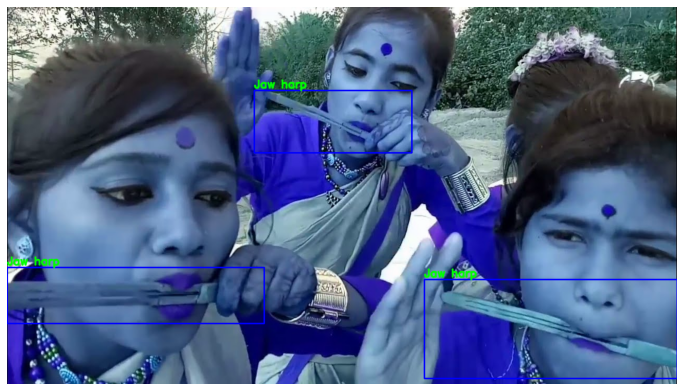

In [22]:


for i in range(len(test_images)):
    # get the image file name for saving output later on
    image_name = test_images[i].split('/')[-1].split('.')[0]
    image = cv2.imread(test_images[i])
    orig_image = image.copy()
    # BGR to RGB
    image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB).astype(np.float32)
    # make the pixel range between 0 and 1
    image /= 255.0
    # bring color channels to front
    image = np.transpose(image, (2, 0, 1)).astype(np.float)
    # convert to tensor
    image = torch.tensor(image, dtype=torch.float).cuda()
    # add batch dimension
    image = torch.unsqueeze(image, 0)
    with torch.no_grad():
        outputs = model(image)
    
    # load all detection to CPU for further operations
    outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
    # carry further only if there are detected boxes
    if len(outputs[0]['boxes']) != 0:
        boxes = outputs[0]['boxes'].data.numpy()
        scores = outputs[0]['scores'].data.numpy()
        # filter out boxes according to `detection_threshold`
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        draw_boxes = boxes.copy()
        # get all the predicited class names
        pred_classes = [classes[i] for i in outputs[0]['labels'].cpu().numpy()]
        
        # draw the bounding boxes and write the class name on top of it
        for j, box in enumerate(draw_boxes):
            cv2.rectangle(orig_image,
                        (int(box[0]), int(box[1])),
                        (int(box[2]), int(box[3])),
                        (0, 0, 255), 2)
            cv2.putText(orig_image, pred_classes[j], 
                        (int(box[0]), int(box[1]-5)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 
                        2, lineType=cv2.LINE_AA)
        # cv2.imshow('Prediction', orig_image)
        # #cv2.waitKey(1)
        plt.figure(figsize=(12,12))
        plt.imshow(orig_image)
        plt.axis('off')
        plt.show()

        cv2.imwrite(f"outputs/{image_name}.jpg", orig_image)
        
cv2.destroyAllWindows()